<div style="color:#00BFFF">

# Nowcasting Consumer Expenditure: 

### Further Analysis for fitting data to model

<div style="color:#00BFFF">

##### Introduction:  Uncovering Reliable Proxies for Consumer Spending Behaviour. 


Essential for finalising the selection of proxies, ensuring they are representative of consumer spending trends and robust under different conditions. 

When selecting a subset of indicators for VAR model from the reduced set of variables:

1. **Economic Theory and Relevance**: Choose variables that are theoretically and empirically relevant to "PCE". They should have economic justification for inclusion in the model.

2. **Statistical Significance**: Consider variables that have shown significant coefficients in the linear regression analysis and a strong correlation with "PCE".

3. **Avoid Overfitting**: With VAR models, including too many variables can lead to overfitting and model complexity. Choose a subset that captures the essential dynamics without being overly complex.

4. **Dimensionality Considerations**: Given the complexity of VAR models, especially with lagged terms, it’s prudent to limit the number of variables. From initial set of 123, a significantly reduced subset based on the above criteria would be appropriate.

5. **Diverse Representation**: Ensure that the chosen indicators cover diverse aspects of the economy and are not too closely related to each other, to provide a comprehensive view.

6. **Iterative Approach**: Model building can be an iterative process. Start with a smaller set of key variables and gradually add or remove variables based on model performance and diagnostics.

<div style="color:#00BFFF">

##### Setup Environment and import libraries

In [1]:
# Run the imports file
%matplotlib inline

In [2]:
# ------- Standard Library Imports -------
import warnings
from datetime import datetime
from pprint import pprint
from typing import List

# ------- Third-Party Library Imports -------
import pandas as pd
from pandas import NaT
import numpy as np

# Utility and display modules
from IPython.display import display, HTML

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Remove warnings
warnings.filterwarnings('ignore')

# Set the display options
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)  
pd.set_option('display.max_colwidth', None)  

/var/folders/30/bhymp02j1fb47cmvs80_1b4m0000gn/T/ipykernel_55622/2839693654.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
#load data generated from [1]M1_clean_and_preprocess.ipynb

#open defn
defn = pd.read_csv('./results/fred/fred_indicator_mappings.csv',index_col=0)

#open joined_dataset.csv
joined_dataset = pd.read_csv('./results/merged_data/joined_dataset_transformed.csv', index_col=0,parse_dates=False)

#open final_proxy_dataset.csv
final_proxy_dataset = pd.read_csv('./results/final_dataset/final_proxy_dataset.csv', index_col=0,parse_dates=False)



In [4]:
refined_datset = final_proxy_dataset.copy()

refined_datset.tail()

,1-Year Treasury Rate,6-Month Treasury Bill:,All Employees: Construction,All Employees: Financial Activities,All Employees: Goods-Producing Industries,All Employees: Government,All Employees: Manufacturing,All Employees: Nondurable goods,All Employees: Retail Trade,All Employees: Service-Providing Industries,All Employees: Total nonfarm,"All Employees: Trade, Transportation & Utilities",All Employees: Wholesale Trade,Capacity Utilization: Manufacturing,Civilian Employment,Civilian Unemployment Rate,Civilians Unemployed for 5-14 Weeks,"Housing Starts, Midwest","Housing Starts, Northeast","Housing Starts, South","Housing Starts, West",Housing Starts: Total New Privately Owned,IP Index,IP: Business Equipment,IP: Final Products (Market Group),IP: Final Products and Nonindustrial Supplies,IP: Manufacturing (SIC),IP: Materials,M1 Money Stock,M2 Money Stock,New Private Housing Permits (SAAR),"New Private Housing Permits, Midwest (SAAR)","New Private Housing Permits, Northeast (SAAR)","New Private Housing Permits, South (SAAR)","New Private Housing Permits, West (SAAR)",Ratio of Help Wanted/No. Unemployed,Real M2 Money Stock,Real Manu. and Trade Industries Sales,Real personal consumption expenditures,Retail and Food Services Sales,PCE
2022-07-01,1.24,1.52,NaN,NaN,0.715264,0.572757,0.761583,0.410257,0.226028,0.848286,0.829815,0.393352,0.626563,0.3200,0.490837,-0.1,5.262704,NaN,NaN,NaN,NaN,NaN,0.816630,2.149355,0.564030,0.508764,0.661687,1.148606,-1.321337,-0.506709,NaN,NaN,NaN,NaN,NaN,0.054294,-1.264904,1.888560,0.733035,-0.340469,1.533394
2022-10-01,0.79,0.92,NaN,NaN,0.626346,0.421828,0.440308,-0.143399,-0.158166,0.541766,0.553508,-0.059078,0.415538,-2.3779,0.255190,0.0,1.593171,NaN,NaN,NaN,NaN,NaN,-1.993597,-2.380810,-0.820252,-1.292597,-2.736535,-2.782494,-0.696709,-0.125014,NaN,NaN,NaN,NaN,NaN,0.085557,-1.601167,0.546969,-0.099006,-0.868696,1.307840
2023-01-01,0.00,0.22,NaN,NaN,0.186211,1.042419,0.015414,0.122926,0.331538,0.671799,0.604504,0.347018,0.316312,0.6711,0.952138,0.0,7.041031,NaN,NaN,NaN,NaN,NaN,1.150573,-0.558715,-0.107414,0.098625,1.185731,2.366223,-2.260271,-1.506098,NaN,NaN,NaN,NaN,NaN,-0.310301,-3.222070,-1.139060,0.877987,1.379186,1.948849
2023-04-01,0.56,0.42,NaN,NaN,0.376019,0.367151,0.069335,-0.492612,-0.024473,0.388879,0.387101,-0.058908,-0.008268,-0.2416,0.111861,0.1,4.703495,NaN,NaN,NaN,NaN,NaN,-0.350314,0.745441,-0.608550,-0.648985,0.015543,0.012144,2.159999,2.180983,NaN,NaN,NaN,NaN,NaN,-0.133004,-0.775006,0.667410,0.527783,1.289197,0.814426
2023-07-01,0.20,0.12,NaN,NaN,0.282244,0.901085,0.053894,-0.309119,0.054090,0.446608,0.423896,0.079691,0.552428,0.1685,0.338548,0.2,9.923368,NaN,NaN,NaN,NaN,NaN,1.006064,-0.185058,0.950138,0.813045,0.542988,1.299016,0.656451,-0.373288,NaN,NaN,NaN,NaN,NaN,-0.055127,-1.667477,1.243294,0.775768,2.118687,1.404393


<div style="color:#00BFFF">

### Further Transformations and considerations for Model fitting


<div style="color:#00BFFF">

##### PCA Analysis


In [5]:
refined_datset.to_csv('final_proxy_dataset.csv')



##### Principal Component Regression (PCR) analysis on this dataset. 

**The steps include:**

1. Handling missing values, if necessary, to ensure the PCA and subsequent regression analysis can be conducted properly.
2. Performing PCA on the predictors to reduce dimensionality and address multicollinearity.
3. Using the principal components obtained from PCA as predictors in a regression model to predict the PCE.

In [6]:
# Check for missing values in the new dataset
missing_values_summary = final_proxy_dataset.isnull().sum()

# Display the number of missing values for each column if any
missing_values_summary[missing_values_summary > 0]


All Employees: Construction                      12
All Employees: Financial Activities              12
Housing Starts, Midwest                          12
Housing Starts, Northeast                        12
Housing Starts, South                            12
Housing Starts, West                             12
Housing Starts: Total New Privately Owned        12
New Private Housing Permits (SAAR)               12
New Private Housing Permits, Midwest (SAAR)      12
New Private Housing Permits, Northeast (SAAR)    12
New Private Housing Permits, South (SAAR)        12
New Private Housing Permits, West (SAAR)         12
dtype: int64

In [7]:
#ffill and bfill missing values
final_proxy_dataset.fillna(method='ffill', inplace=True)
final_proxy_dataset.fillna(method='bfill', inplace=True)

import missingno as msno

# # Visualize missing values
# msno.matrix(refined_datset)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Splitting the dataset to keep the last 4 observations aside
df_train = final_proxy_dataset.iloc[:-3]
df_test = final_proxy_dataset.iloc[-3:]


# Separate predictors and target for training
X_train = df_train.drop(columns=['PCE'])
y_train = df_train['PCE']

# Keeping the last 4 observations of PCE in variable C
C = final_proxy_dataset['PCE'].iloc[-3:]

# Information about the cut for visualization
cut_date = df_train.index[-16]  # 16 observations before the last 4
actual_pce_for_fan_chart = df_train.loc[cut_date:]['PCE']

# Preparing the full dataset for later comparison
full_actual_pce = final_proxy_dataset['PCE']

print("Data preparation complete.")
print("Cut-off date for fan chart base:", cut_date)

Data preparation complete.
Cut-off date for fan chart base: 2019-01-01


In [9]:
# Standardizing the predictors and applying PCA within a pipeline, followed by Linear Regression
pipeline = make_pipeline(StandardScaler(), PCA(n_components=4), LinearRegression())

# Fitting the model to the training data
pipeline.fit(X_train, y_train)

# Predicting the next 4 quarters - using df_test as it contains the predictors for these periods
X_test = df_test.drop(columns=['PCE'])
predicted_pce = pipeline.predict(X_test)

# Displaying the predicted PCE values
predicted_pce

array([1.8552817 , 0.84627159, 1.56516909])

In [10]:
# Performing PCA on the standardized predictors from the training dataset up to the end of 2022
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Fitting PCA
pca = PCA()
pca.fit(X_scaled)

# Extracting factor loadings (the PCA components)
factor_loadings = pca.components_

# Mapping factor loadings to original variable names
factor_loadings_df = pd.DataFrame(factor_loadings, columns=X_train.columns, index=[f'PC{i+1}' for i in range(factor_loadings.shape[0])])

# Displaying factor loadings for the first few principal components for brevity
factor_loadings_df.head()

,1-Year Treasury Rate,6-Month Treasury Bill:,All Employees: Construction,All Employees: Financial Activities,All Employees: Goods-Producing Industries,All Employees: Government,All Employees: Manufacturing,All Employees: Nondurable goods,All Employees: Retail Trade,All Employees: Service-Providing Industries,All Employees: Total nonfarm,"All Employees: Trade, Transportation & Utilities",All Employees: Wholesale Trade,Capacity Utilization: Manufacturing,Civilian Employment,Civilian Unemployment Rate,Civilians Unemployed for 5-14 Weeks,"Housing Starts, Midwest","Housing Starts, Northeast","Housing Starts, South","Housing Starts, West",Housing Starts: Total New Privately Owned,IP Index,IP: Business Equipment,IP: Final Products (Market Group),IP: Final Products and Nonindustrial Supplies,IP: Manufacturing (SIC),IP: Materials,M1 Money Stock,M2 Money Stock,New Private Housing Permits (SAAR),"New Private Housing Permits, Midwest (SAAR)","New Private Housing Permits, Northeast (SAAR)","New Private Housing Permits, South (SAAR)","New Private Housing Permits, West (SAAR)",Ratio of Help Wanted/No. Unemployed,Real M2 Money Stock,Real Manu. and Trade Industries Sales,Real personal consumption expenditures,Retail and Food Services Sales
PC1,-0.089646,-0.090766,-0.183188,-0.167178,-0.200084,-0.133199,-0.192695,-0.178852,-0.202300,-0.200033,-0.211132,-0.214988,-0.202403,-0.174604,-0.202778,0.200804,0.163858,-0.108834,-0.106372,-0.113742,-0.122565,-0.124366,-0.195696,-0.173438,-0.179892,-0.195999,-0.193508,-0.181497,0.137440,0.120947,-0.122789,-0.110672,-0.118570,-0.103951,-0.122180,-0.163045,0.124321,-0.115666,-0.094321,-0.052620
PC2,-0.008038,-0.007374,0.070501,0.072518,-0.048077,-0.058287,-0.096997,-0.124366,-0.079667,-0.103857,-0.102236,-0.081705,-0.055506,-0.091151,-0.097609,0.135589,0.151130,0.256970,0.256214,0.285963,0.293412,0.303848,-0.077093,-0.057530,-0.028762,-0.033529,-0.049409,-0.108503,0.146062,0.116224,0.301485,0.265079,0.252145,0.272484,0.294975,-0.077695,0.095271,0.024969,0.057946,0.073806
PC3,0.170595,0.169933,-0.010207,-0.101346,0.021160,-0.285448,0.033636,-0.030442,-0.102716,-0.206551,-0.165806,-0.103057,-0.077274,0.240251,-0.140057,0.134879,0.184618,-0.001819,-0.064929,-0.046929,-0.054637,-0.048162,0.208260,0.212959,0.248351,0.223773,0.230133,0.172014,0.224308,0.135913,-0.057825,-0.009566,-0.050139,-0.056662,-0.070823,0.007815,0.122537,0.327395,0.215794,0.272401
PC4,-0.365081,-0.371871,-0.215236,-0.095615,-0.287516,0.179611,-0.282036,-0.210461,0.049621,0.047460,-0.024700,-0.046187,-0.192519,0.067493,0.039994,-0.035638,-0.179561,0.106832,0.036390,-0.014344,-0.012377,0.017385,0.088269,0.051467,0.113752,0.099081,0.099115,0.076767,-0.258869,-0.236063,-0.002708,0.097404,0.003982,-0.041877,-0.010878,-0.024119,0.062886,0.129621,0.317437,0.177393
PC5,0.472090,0.465314,-0.236827,-0.266708,-0.177865,0.091724,-0.156779,-0.156995,-0.081002,-0.016044,-0.040783,-0.095399,-0.093297,0.036217,0.008185,-0.008363,-0.097829,0.125700,0.029204,-0.009091,0.011534,0.030644,0.030177,-0.045970,-0.012620,-0.014781,0.020547,0.064653,-0.160469,-0.341189,0.035179,0.132250,0.024173,-0.002992,0.022113,-0.058189,-0.312947,-0.054732,-0.103682,-0.062945


In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(C, predicted_pce)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(C, predicted_pce, squared=False)  # Set squared=False for RMSE
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 0.09539646058888218
Root Mean Squared Error (RMSE): 0.10896195252781732


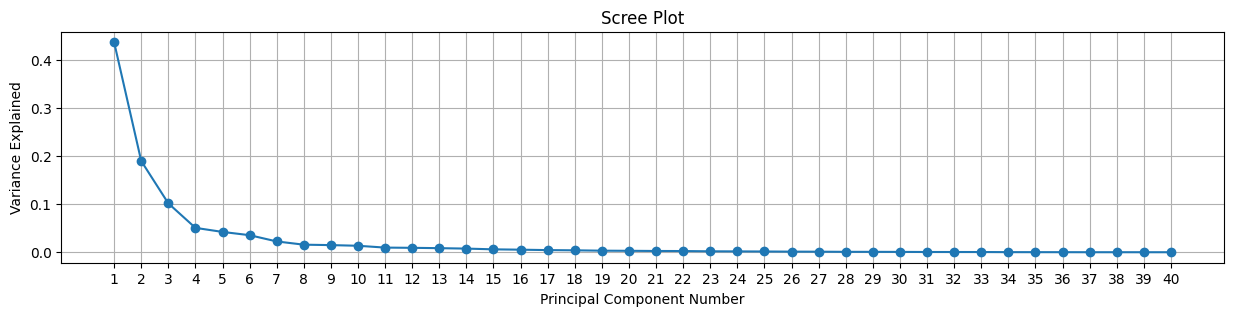

In [12]:
# # Variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Scree Plot from the PCA performed earlier
plt.figure(figsize=(15, 3))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Principal Component Number')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)

plt.show()



We'll now perform PCR, which involves:
1. Standardizing the predictor variables.
2. Applying PCA to reduce dimensionality.
3. Conducting a regression analysis using the principal components to predict the PCE.

In [13]:
# Dates for plotting
dates_for_fan_chart = full_actual_pce.loc[cut_date:].index
dates_for_predictions = df_test.index

# calculate uncertainty margin based on residuals from the training data
# First, get predictions for the training data to calculate residuals
y_train_pred = pipeline.predict(X_train)

# Calculate residuals
residuals = y_train - y_train_pred

# Estimate prediction uncertainty as the standard deviation of the residuals
prediction_uncertainty_std = np.std(residuals)
# Combine the actual PCE data before the cutoff with the actual hidden PCE values
combined_actual_pce = pd.concat([actual_pce_for_fan_chart, C])

# Ensure dates are continuous for plotting (if there's a discontinuity in the index, this will automatically handle it)
combined_dates = combined_actual_pce.index

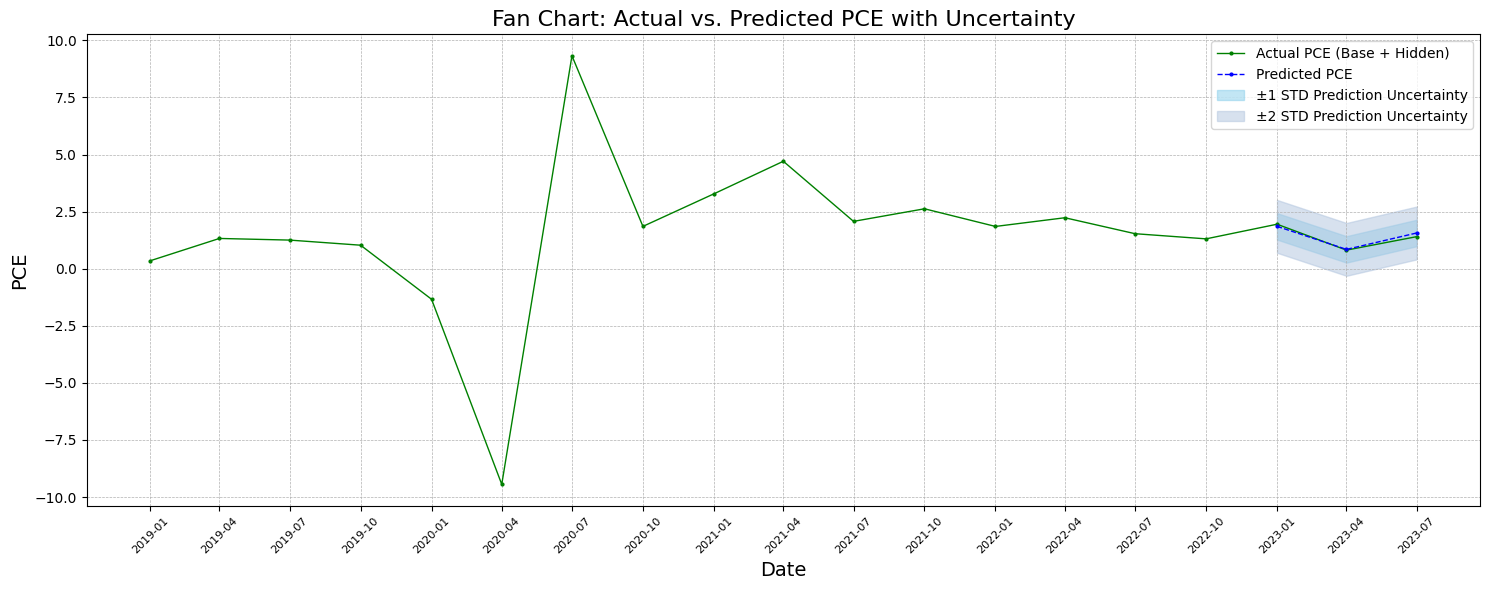

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert string dates to datetime objects for plotting
dates_for_fan_chart_dt = pd.to_datetime(dates_for_fan_chart)

plt.figure(figsize=(15, 6))

# Convert 'combined_dates' to datetime for plotting 
combined_dates_dt = pd.to_datetime(combined_dates)

# Plot Actual PCE
plt.plot(combined_dates_dt, combined_actual_pce, color='green', linewidth=1, marker='o', markersize=2,label='Actual PCE (Base + Hidden)')

# Assuming 'dates_for_predictions' aligns with 'dates_for_fan_chart' for the predicted part
dates_for_predictions_dt = pd.to_datetime(dates_for_predictions)

# Plot Predicted PCE
plt.plot(dates_for_predictions_dt, predicted_pce, color='blue', linestyle='--', linewidth=1,marker='o', markersize=2, label='Predicted PCE')

# # Plot Uncertainty Areas
std_devs = [1, 2]  # Representing 1, 2, standard deviations
colors = ['skyblue',  'lightsteelblue']  # Different shades for each level 'lightskyblue',

# Plot Uncertainty Areas
for std_dev, color in zip(std_devs, colors):
    plt.fill_between(dates_for_predictions_dt, 
                     predicted_pce - prediction_uncertainty_std * std_dev, 
                     predicted_pce + prediction_uncertainty_std * std_dev, 
                     color=color, 
                     alpha=0.5, 
                     label=f'±{std_dev} STD Prediction Uncertainty')

plt.title('Fan Chart: Actual vs. Predicted PCE with Uncertainty', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('PCE', fontsize=14)

# Set the x-axis to display dates at the intervals specified in 'dates_for_fan_chart'
plt.xticks(dates_for_fan_chart_dt, [date.strftime('%Y-%m') for date in dates_for_fan_chart_dt], rotation=45, fontsize=8)

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

